In [1]:
#!/usr/bin/env python
import os

import h5py
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn 
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
import mobilenetv3
import os
import time
import copy
import csv
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch_pruning as tp
from mobilenetv3 import mobilenetv3
from collections import defaultdict
from torch.utils.benchmark import Timer
from torchinfo import summary
from fvcore.nn import FlopCountAnalysis, parameter_count
import torch.autograd.profiler as profiler
import torch.profiler as profiler
from collections import OrderedDict


In [2]:
# train_data = '/home/engr_fm_alikhan/august_22_beam_train.h5'
# val_data = '/home/engr_fm_alikhan/august_22_beam_test.h5'
train_data = '/home/mohammad.hallaq/workarea/AoA-Pruning/data_h5py_files/r22_train.h5'
val_data = '/home/mohammad.hallaq/workarea/AoA-Pruning/data_h5py_files/r22_test.h5'
checkpoint_dir = '/home/mohammad.hallaq/workarea/MobileNet_compression/checkpoints-Copy2'
checkpoint_filename = os.path.join(checkpoint_dir, 'august22_beam_t.ckpt')
checkpoint =torch.load(checkpoint_filename)

In [3]:
example_length = 4096
batch_size = 128
epochs = 20

hparams = {
    'drop_path_rate': 0.2,
    'drop_rate': 0.7,
    'learning_rate': 1e-3,
    'wd': 0.01
}


In [4]:
class R22_H5_Dataset(Dataset):
    def __init__(self, data_file, label='label', iqlabel='iq_data'):
        self.data_file = data_file
        self.label = label
        self.iqlabel = iqlabel

    def __len__(self):
        with h5py.File(self.data_file, 'r') as f:
            length = len(f[self.label])
        return length

    def __getitem__(self, idx):
        with h5py.File(self.data_file, 'r') as f:
            iq_data = f[self.iqlabel][idx]
            label = f[self.label][idx]
        return iq_data, label
    
    def get_metadata(self, idx):
        with h5py.File(self.data_file, 'r') as f:
            metadata = {
                'recording': f['recording'][idx].decode('utf-8)'),
                'category': f['category'][idx].decode('utf-8)')
            }
        return metadata




In [5]:
train_set = R22_H5_Dataset(train_data)
val_set = R22_H5_Dataset(val_data)
print(f'Training Set: {len(train_set)} examples')
print(f'Validation Set: {len(val_set)} examples')


Training Set: 298350 examples
Validation Set: 74685 examples


In [6]:
num_classes = train_set[0][1].shape[0]

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    )
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=128,
    shuffle=False,
    num_workers=8
    )

In [7]:
original_model = mobilenetv3(
    model_size='mobilenetv3_small_050',
    num_classes=num_classes,
    drop_rate=hparams['drop_rate'],
    drop_path_rate=hparams['drop_path_rate'],
    in_chans=8
)

checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    filename=checkpoint_filename,
    save_top_k=True,
    verbose=True,
    monitor='val_loss',
    mode='min',
)

device = 'gpu' if torch.cuda.is_available() else 'cpu'

trainer = L.Trainer(
    max_epochs=epochs,
    callbacks=checkpoint_callback,
    accelerator=device,
    devices=1,
    benchmark=True,
    precision='bf16-mixed',
)
torch.set_float32_matmul_precision('high')

with open('original_model_structure.txt', 'w') as f:
    summary_str = summary(original_model, input_size=(1, 8, 4096), verbose=0)
    f.write(str(summary_str))

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
class RFClassifier(L.LightningModule):
    def __init__(self, model):
        super().__init__()

        self.model = model
        self.lr = hparams['learning_rate']

    def forward(self,x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), 
                                      lr = hparams['learning_rate'],
                                      weight_decay = hparams['wd'],
                                      )
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            T_max=len(train_loader)*epochs,
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'step'
            }
        }
       
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss,
            on_epoch=True,
            prog_bar=True,
            )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss, prog_bar=True)

In [9]:
def remove_prefix_from_state_dict(state_dict, prefix='model.'):

    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith(prefix):
            new_state_dict[k[len(prefix):]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

In [10]:

# checkpoint = torch.load(checkpoint_filename+".ckpt", map_location=lambda storage, loc: storage)
# original_model.load_state_dict(checkpoint['state_dict'])

# # # # Remove the prefix from the state_dict if necessary
checkpoint['state_dict'] = remove_prefix_from_state_dict(checkpoint['state_dict'], prefix='model.')

original_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [11]:
def analyze_model_and_save_to_csv(model, example_inputs, val_loader, device=None, iterations=1, csv_file='model_analysis.csv', model_name=None):
  
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    first_batch = next(iter(val_loader))  
    input_tensor, true_angles = first_batch
    input_tensor = input_tensor.to(device)

    model.to(device)
    example_inputs = input_tensor.to(device)

    analysis_results = {
        'model_name': model_name if model_name else model.__class__.__name__,
        'model_size_mb (MB)': None,
        'GFLOPs (GFLOPs)': None,
        'Total_Params (count)': None,
        'First_Forward_Pass_Time (s)': None,
        'Training_Time (s)': None,
        'Inference_Time (s)': None,
        'CUDA_Time (ms)': None,
        'CPU_Time (ms)': None,
        'mse': None,
        'mae': None
    }

    try:
        model.to(device)
        example_inputs = example_inputs.to(device)

        flops, params = tp.utils.count_ops_and_params(model, example_inputs)
        analysis_results['GFLOPs (GFLOPs)'] = flops   # Convert to GFLOPs
        analysis_results['Total_Params (count)'] = params

    except Exception:
        pass  


    try:
        torch.save(model.state_dict(), "temp.pth")
        model_size = os.path.getsize("temp.pth") / (1024 * 1024)  # Convert to MB
        os.remove("temp.pth")
        analysis_results['model_size_mb (MB)'] = model_size
    except Exception:
        pass

    try:
        model.eval()
        with torch.no_grad():
            start_time = time.time()
            _ = model(example_inputs)
            end_time = time.time()
        analysis_results['First_Forward_Pass_Time (s)'] = end_time - start_time
    except Exception:
        pass

    try:
        start_time = time.time()
        for _ in range(iterations):
            with torch.no_grad():
                _ = model(example_inputs)
        end_time = time.time()
        analysis_results['Inference_Time (s)'] = (end_time - start_time) / iterations
    except Exception:
        pass


    try:
        model.eval()
        with torch.no_grad():
            if torch.cuda.is_available():
                torch.cuda.synchronize()  
                with profiler.profile(use_cuda=True) as prof:
                    _ = model(example_inputs)
               
                cuda_time_total = sum(evt.cuda_time for evt in prof.key_averages())
                cpu_time_total = sum(evt.cpu_time_total for evt in prof.key_averages())
                analysis_results['CUDA_Time (ms)'] = cuda_time_total / 1e3
                analysis_results['CPU_Time (ms)'] = cpu_time_total / 1e3
            else:

                with profiler.profile(use_cuda=False) as prof:
                    _ = model(example_inputs)
                
                cpu_time_total = sum(evt.cpu_time_total for evt in prof.key_averages())
                analysis_results['CPU_Time (ms)'] = cpu_time_total / 1e3
    except Exception as e:
        print(f"Error during profiling: {e}")
        pass


    try:
        model.eval()
        y_preds = []
        y_true = []
        with torch.inference_mode():
            for sample in val_loader:
                data, target = sample[0].to(device), sample[1].to(device)
                y_true += target.tolist()
                output = model(data)
                y_preds += output.cpu().tolist()

        y_true = np.array(y_true)
        y_preds = np.array(y_preds)

        mse = np.square(y_true - y_preds).mean()
        mae = np.absolute(y_true - y_preds).mean()

        analysis_results['mse'] = mse
        analysis_results['mae'] = mae
    except Exception:
        pass
    

    file_exists = os.path.isfile(csv_file)
    
    with open(csv_file, mode='a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=analysis_results.keys())
        
        if not file_exists:
            writer.writeheader()  
        
        writer.writerow(analysis_results)  

    return analysis_results




In [12]:
def analyze_model_and_save_to_csv(model, example_inputs, val_loader, device=None, iterations=1, csv_file='model_analysis.csv', model_name=None):
  
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    first_batch = next(iter(val_loader))
    input_tensor, true_angles = first_batch
    input_tensor = input_tensor.to(device)


    model.to(device)
    example_inputs = input_tensor.to(device)
    

    analysis_results = {
        'model_name': model_name if model_name else model.__class__.__name__,
        'model_size_mb (MB)': None,
        'GFLOPs (GFLOPs)': None,
        'Total_Params (count)': None,
        'First_Forward_Pass_Time (s)': None,
        'Training_Time (s)': None,
        'Inference_Time (s)': None,
        'CUDA_Time (ms)': None,
        'CPU_Time (ms)': None,
        'mse': None,
        'mae': None
    }
    
 
    try:
        model.to(device)
        example_inputs = example_inputs.to(device)
    
 
        flops, params = tp.utils.count_ops_and_params(model, example_inputs)
        analysis_results['GFLOPs (GFLOPs)'] = flops  
        analysis_results['Total_Params (count)'] = params

    except Exception:
        pass 


    try:
        torch.save(model.state_dict(), "temp.pth")
        model_size = os.path.getsize("temp.pth") / (1024 * 1024)  # Convert to MB
        os.remove("temp.pth")
        analysis_results['model_size_mb (MB)'] = model_size
    except Exception:
        pass


    try:
        model.eval()
        with torch.no_grad():
            start_time = time.time()
            _ = model(example_inputs)
            end_time = time.time()
        analysis_results['First_Forward_Pass_Time (s)'] = end_time - start_time
    except Exception:
        pass

    try:
        iterations = 100 # Number of iterations within each test
        num_tests = 10 # Number of times to run the inference test
        all_times = [] # To store the inference times of each test

        for test in range(num_tests):
            start_time = time.time()
            for _ in range(iterations):
                with torch.no_grad():
                    _ = model(example_inputs)
            end_time = time.time()
            inference_time = (end_time - start_time) / iterations
            all_times.append(inference_time)
        
        average_inference_time = sum(all_times) / num_tests
        
        analysis_results['Inference_Time (s)'] = average_inference_time
    except Exception:
        pass


    try:
        model.eval()
        with torch.no_grad():
            if torch.cuda.is_available():
                torch.cuda.synchronize()  
                with profiler.profile(use_cuda=True) as prof:
                    _ = model(example_inputs)
                # Collect CUDA times
                cuda_time_total = sum(evt.cuda_time for evt in prof.key_averages())
                cpu_time_total = sum(evt.cpu_time_total for evt in prof.key_averages())
                analysis_results['CUDA_Time (ms)'] = cuda_time_total / 1e3
                analysis_results['CPU_Time (ms)'] = cpu_time_total / 1e3
            else:
                with profiler.profile(use_cuda=False) as prof:
                    _ = model(example_inputs)
                # Collect CPU times only
                cpu_time_total = sum(evt.cpu_time_total for evt in prof.key_averages())
                analysis_results['CPU_Time (ms)'] = cpu_time_total / 1e3
    except Exception as e:
        print(f"Error during profiling: {e}")
        pass

    try:
        model.eval()
        y_preds = []
        y_true = []
        with torch.inference_mode():
            for sample in val_loader:
                data, target = sample[0].to(device), sample[1].to(device)
                y_true += target.tolist()
                output = model(data)
                y_preds += output.cpu().tolist()

        y_true = np.array(y_true)
        y_preds = np.array(y_preds)


        mse = np.square(y_true - y_preds).mean()
        mae = np.absolute(y_true - y_preds).mean()

        analysis_results['mse'] = mse
        analysis_results['mae'] = mae
    except Exception:
        pass
    

    file_exists = os.path.isfile(csv_file)
    
    with open(csv_file, mode='a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=analysis_results.keys())
        
        if not file_exists:
            writer.writeheader()  
        
        writer.writerow(analysis_results)  

    return analysis_results

In [13]:

checkpoint_filename='/home/mohammad.hallaq/workarea/MobileNet_compression/checkpoints-Copy2/august22_beam_t.ckpt'

checkpoint = torch.load(checkpoint_filename)


print("Keys in checkpoint:", checkpoint.keys())

if 'epoch' in checkpoint:
    print("Epoch:", checkpoint['epoch'])




Keys in checkpoint: dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])
Epoch: 72


In [14]:
example_inputs = torch.randn(1, 8, 4096) 

results = analyze_model_and_save_to_csv(original_model, example_inputs, val_loader, device=None, iterations=1, csv_file='model_analysis_cross.csv')


for key, value in results.items():
    print(f"{key}: {value}")

/home/mohammad.hallaq/workarea/venv/lib/python3.10/site-packages/torch/profiler/profiler.py:599: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2024-09-27 00:58:27 1389518:1389518 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-09-27 00:58:27 1389518:1389518 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-09-27 00:58:27 1389518:1389518 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


model_name: MobileNetV3
model_size_mb (MB): 2.1971359252929688
GFLOPs (GFLOPs): 23439648.0
Total_Params (count): 548482
First_Forward_Pass_Time (s): 0.00824737548828125
Training_Time (s): None
Inference_Time (s): 0.015605582952499388
CUDA_Time (ms): 3.107579305629819
CPU_Time (ms): 54.279
mse: 1.2235874767158266
mae: 0.5767367116852589


In [15]:
checkpoint['state_dict']

OrderedDict([('model.conv_stem.weight',
              tensor([[[-2.1471e-01, -2.5580e-01, -3.1300e-01],
                       [-5.4638e-02, -7.1585e-02, -4.1467e-02],
                       [-5.5546e-02, -9.1402e-02, -1.7051e-01],
                       [-3.7766e-02, -8.4714e-02, -1.6148e-01],
                       [-1.3424e-01,  1.0588e-01,  1.9028e-01],
                       [ 1.0216e-01,  3.5393e-02,  1.3321e-01],
                       [-2.6263e-01, -1.4273e-01, -2.1540e-01],
                       [ 1.0295e-01,  1.4519e-01,  1.0019e-01]],
              
                      [[ 2.4470e-01,  1.9948e-01,  2.2333e-01],
                       [-8.7865e-02, -1.5894e-02, -8.9050e-03],
                       [ 1.2185e-01,  9.3297e-02,  2.3777e-01],
                       [-2.5500e-01, -1.7609e-01, -1.6513e-01],
                       [ 6.4104e-02,  6.4202e-02, -1.6102e-02],
                       [ 1.4851e-01,  1.5250e-01,  1.2428e-01],
                       [ 2.1845e-01,  1.8078e-01

In [16]:
def plot_quiver(loader, model, title_suffix, file_suffix):
    device = next(model.parameters()).device
    model.to(device)
    
    with torch.no_grad():
        predictions_dict = defaultdict(list)
        for batch in loader:
            inputs, true_angles = batch
            inputs, true_angles = inputs.to(device), true_angles.to(device)
            predicted = model(inputs).cpu().numpy()
            true_angles = true_angles.cpu().numpy()
            for i in range(len(true_angles)):
                key = tuple(true_angles[i])
                predictions_dict[key].append(predicted[i])

        mean_predictions = {}
        average_base_angles = []

        for key, preds in predictions_dict.items():
            mean_pred = np.mean(preds, axis=0)
            mean_predictions[key] = mean_pred
            average_base_angles.append(mean_pred)

        true_azimuths = []
        true_elevations = []
        pred_azimuth_diffs = []
        pred_elevation_diffs = []

        for (true_azimuth, true_elevation), mean_pred in mean_predictions.items():
            true_azimuths.append(true_azimuth)
            true_elevations.append(true_elevation)
            pred_azimuth_diffs.append(mean_pred[0] - true_azimuth)
            pred_elevation_diffs.append(mean_pred[1] - true_elevation)

        pred_azimuth_diffs = np.array(pred_azimuth_diffs)
        pred_elevation_diffs = np.array(pred_elevation_diffs)

        plt.figure(figsize=(10, 10))
        plt.scatter(true_azimuths, true_elevations, color='red', label='True Angles')
        plt.quiver(true_azimuths, true_elevations,
                   pred_azimuth_diffs,
                   pred_elevation_diffs,
                   angles='xy', scale_units='xy', scale=1, color='blue', label='Predicted Angles')

        plt.xlim([-55, 55])
        plt.ylim([-55, 55])

        plt.xlabel('Azimuth')
        plt.ylabel('Elevation')
        plt.title(f'Averaged Quiver Plot of True vs Predicted Angles {title_suffix}')
        plt.grid()
        plt.legend()
        plt.savefig(f'Quiver_plot_{file_suffix}.png')
        plt.show()
        vector_magnitudes = np.sqrt(pred_azimuth_diffs ** 2 + pred_elevation_diffs ** 2)

        plt.figure(figsize=(10, 6))
        plt.hist(vector_magnitudes, bins=50, color='purple', alpha=0.7, label='Vector Magnitudes')
        plt.xlabel('Magnitude')
        plt.ylabel('Frequency')
        plt.title(f'Histogram of Magnitudes of Quiver Vectors {title_suffix}')
        plt.legend()
        plt.savefig(f'Histogram_plot_{file_suffix}.png')
        plt.show()

    # return true_azimuths, true_elevations, pred_azimuth_diffs, pred_elevation_diffs





In [12]:
pruned_model = torch.load('/home/mohammad.hallaq/workarea/MobileNet_compression/best_model.pth')

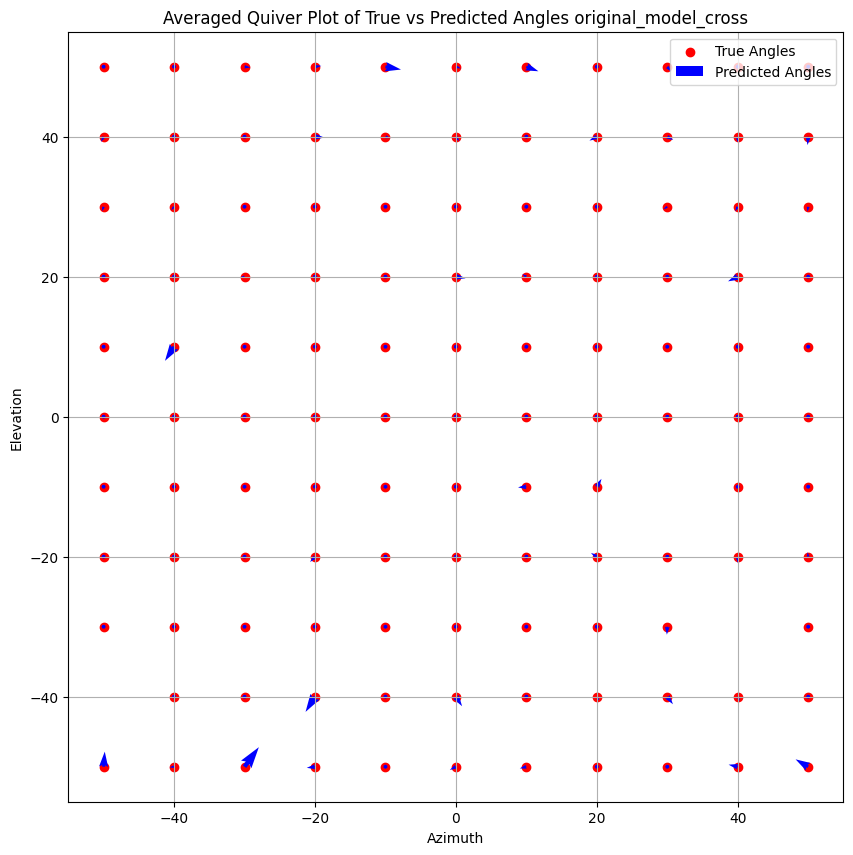

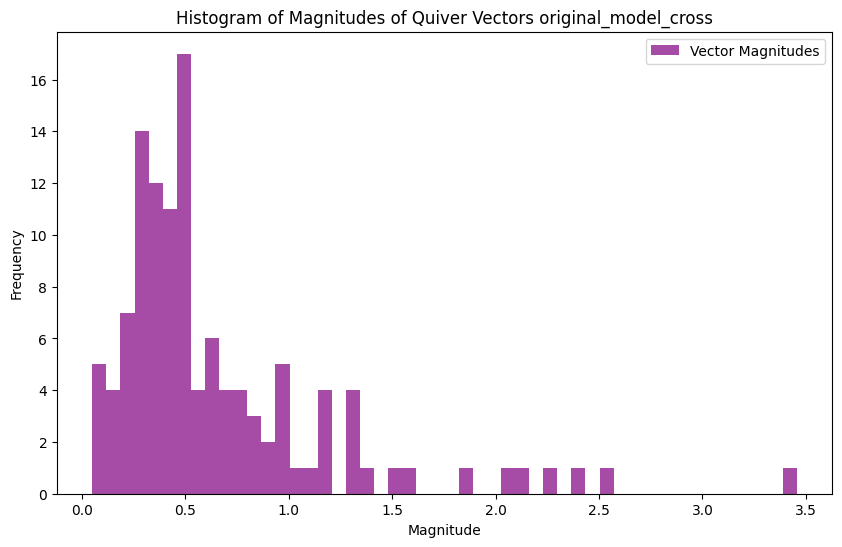

In [17]:
plot_quiver( val_loader, original_model,'original_model_cross','original_model_cross')